# Cal-CRAI Index: Built Environment Domain

**Order of operations**:
- Metric handling
   - Retrieve data
   - Min-max standardization
   - Set vulnerability orientation (pos for vulnerable, neg for resilience)
- Calculate indicators
   - Min-max standardization
- Calculate domain score
- Visualizations

Note: Functions and figures within this notebook are in development

In [1]:
import pandas as pd
import os
import sys
import warnings

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata
from scripts.utils.index_plot import plot_domain, plot_region_domain
from scripts.utils.calculate_index import (handle_outliers, min_max_standardize, process_domain_csv_files, 
                                        compute_averaged_indicators, compute_summed_indicators, indicator_dicts, 
                                        add_census_tracts, domain_summary_stats)

## Step 1: Metric level
### 1a) Retrieve metric files and process

In [2]:
# set-up
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/'

pull_csv_from_directory(bucket_name, aws_dir, output_folder='aws_csvs', search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/.


In [3]:
# domain-specific
domain_prefix = 'built_'

input_folder = r'C:/Users/jespi/eagle/carb-climate-index-2/aws_csvs'
output_folder = domain_prefix + "folder"
meta_csv = r'C:/Users/jespi/eagle/carb-climate-index-2/metadata/Full Data Pipeline Notes - 4_ Calculate Metric.csv'
merged_output_file = 'concatenate_built_environment_metrics.csv'

metric_vulnerable_resilient_dict = process_domain_csv_files(domain_prefix, input_folder, output_folder, meta_csv, merged_output_file)

Processed and saved 20 CSV files within built_domain.

Metric resilience/vulnerable dictionary created and called: metric_vulnerable_resilient_dict

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 0
Replacing infinite entries (if any) with NaN
Number of infinite entries in the DataFrame after replacement: 0

File processing complete, dataframe will now be saved as a .csv
Processed CSV saved as concatenate_built_environment_metrics.csv


### Take a look at the resulting dictionary
We will use this later to refactor 'resilient' metrics

In [4]:
metric_vulnerable_resilient_dict

{'vulnerable': ['low_internet_download_flag',
  'percent_housing_before_1980',
  'percent_mobile_homes',
  'percent_without_kitchen_facilities_or_plumbing',
  'estimated_total_vacant_housing_units',
  'avg_num_psps_event',
  'number_of_bottlenecks'],
 'resilient': ['cellular_towers_data_count',
  'percent_underground_transmission_lines',
  'microwave_towers_data_count',
  'mobile_towers_data_count',
  'paging_towers_data_count',
  'power_plant_count',
  'radio_towers_data_count',
  'number_of_airports',
  'numbers_of_bridges',
  'highway_length_in_miles',
  'railway_length_in_miles',
  'tv_contour_data_count',
  'num_exclusive_wastewater_facilities']}

### Now, take a look at the merged singluar csv file

In [5]:
# read-in and view processed data
processed_built_df = pd.read_csv('concatenate_built_environment_metrics.csv')
processed_built_df

,GEOID,low_internet_download_flag,cellular_towers_data_count,percent_underground_transmission_lines,percent_housing_before_1980,percent_mobile_homes,percent_without_kitchen_facilities_or_plumbing,estimated_total_vacant_housing_units,microwave_towers_data_count,mobile_towers_data_count,...,power_plant_count,avg_num_psps_event,radio_towers_data_count,number_of_airports,number_of_bottlenecks,numbers_of_bridges,highway_length_in_miles,railway_length_in_miles,tv_contour_data_count,num_exclusive_wastewater_facilities
0,6001400100,0.0,2.0,0.0,15.032680,2.0,0.0,119.0,734.0,28.0,...,0.0,0.800000,19.0,3.0,5.0,302.0,920.838160,181.100468,13.0,16.0
1,6001400200,0.0,2.0,0.0,90.639269,0.0,0.6,37.0,734.0,28.0,...,0.0,0.400000,19.0,3.0,5.0,302.0,920.838160,181.100468,13.0,16.0
2,6001400300,0.0,2.0,0.0,82.714177,0.0,0.0,213.0,734.0,28.0,...,0.0,0.400000,19.0,3.0,5.0,302.0,920.838160,181.100468,13.0,16.0
3,6001400400,0.0,2.0,0.0,92.159091,0.0,0.6,215.0,734.0,28.0,...,0.0,0.400000,19.0,3.0,5.0,302.0,920.838160,181.100468,13.0,16.0
4,6001400500,0.0,2.0,0.0,89.874926,0.0,0.0,141.0,734.0,28.0,...,0.0,0.400000,19.0,3.0,5.0,302.0,920.838160,181.100468,13.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,1.0,3.0,0.0,14.730290,0.0,2.7,14.0,45.0,NaN,...,0.0,1.000000,1.0,1.0,1.0,78.0,143.846206,59.620857,4.0,7.0
9125,6115041001,1.0,3.0,0.0,43.787777,14.8,11.5,106.0,45.0,NaN,...,0.0,1.500000,1.0,1.0,1.0,78.0,143.846206,59.620857,4.0,7.0
9126,6115041002,1.0,3.0,0.0,33.126294,6.0,0.0,183.0,45.0,NaN,...,1.0,2.066667,1.0,1.0,1.0,78.0,143.846206,59.620857,4.0,7.0
9127,6115041101,1.0,3.0,0.0,44.197292,28.8,1.5,384.0,45.0,NaN,...,2.0,2.733333,1.0,1.0,1.0,78.0,143.846206,59.620857,4.0,7.0


### 1b) Min-max standardization
Metrics are min-max standardized on 0.01 to 0.99 scale.

In [6]:
# standardizing our df
columns_to_process = [col for col in processed_built_df.columns if col != 'GEOID']
min_max_metrics = min_max_standardize(processed_built_df, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


In [9]:
# this will show the standardized columns as well as their max and min column counterparts used in the process

#min_max_metrics

Isolate for GEOID and standardized columns exclusively

In [7]:
words = ['GEOID','standardized']
selected_columns = []
for word in words:
    selected_columns.extend(min_max_metrics.columns[min_max_metrics.columns.str.contains(word)].tolist())
min_max_standardized_built_metrics_df = min_max_metrics[selected_columns]

In [8]:
min_max_standardized_built_metrics_df.head()

,GEOID,low_internet_download_flag_min_max_standardized,cellular_towers_data_count_min_max_standardized,percent_underground_transmission_lines_min_max_standardized,percent_housing_before_1980_min_max_standardized,percent_mobile_homes_min_max_standardized,percent_without_kitchen_facilities_or_plumbing_min_max_standardized,estimated_total_vacant_housing_units_min_max_standardized,microwave_towers_data_count_min_max_standardized,mobile_towers_data_count_min_max_standardized,...,power_plant_count_min_max_standardized,avg_num_psps_event_min_max_standardized,radio_towers_data_count_min_max_standardized,number_of_airports_min_max_standardized,number_of_bottlenecks_min_max_standardized,numbers_of_bridges_min_max_standardized,highway_length_in_miles_min_max_standardized,railway_length_in_miles_min_max_standardized,tv_contour_data_count_min_max_standardized,num_exclusive_wastewater_facilities_min_max_standardized
0,6001400100,0.0,0.076923,0.0,0.150327,0.02,0.000000,0.024653,0.17889,0.232759,...,0.0,0.166667,0.206897,0.142857,0.444444,0.165525,0.199691,0.201786,0.705882,0.254237
1,6001400200,0.0,0.076923,0.0,0.906393,0.00,0.006283,0.007665,0.17889,0.232759,...,0.0,0.083333,0.206897,0.142857,0.444444,0.165525,0.199691,0.201786,0.705882,0.254237
2,6001400300,0.0,0.076923,0.0,0.827142,0.00,0.000000,0.044127,0.17889,0.232759,...,0.0,0.083333,0.206897,0.142857,0.444444,0.165525,0.199691,0.201786,0.705882,0.254237
3,6001400400,0.0,0.076923,0.0,0.921591,0.00,0.006283,0.044541,0.17889,0.232759,...,0.0,0.083333,0.206897,0.142857,0.444444,0.165525,0.199691,0.201786,0.705882,0.254237
4,6001400500,0.0,0.076923,0.0,0.898749,0.00,0.000000,0.029211,0.17889,0.232759,...,0.0,0.083333,0.206897,0.142857,0.444444,0.165525,0.199691,0.201786,0.705882,0.254237


### 1c) Set vulnerability orientation
* High values indicate vulnerability
* Low values indicate resiliency

Some metrics indicate a communities resistance rather than vulnerablity. For example, number of emergency personel per 10,000 people represents a communities ability to respond to emergencies. For this metric, the higher the number, the more resilient. So we identify these 'resilient' metrics with our `metric_vulnerable_resilient_dict` dictionary and subtract their values from 1 so all high values indicate vulnerability

In [9]:
metric_vulnerable_resilient_dict

{'vulnerable': ['low_internet_download_flag',
  'percent_housing_before_1980',
  'percent_mobile_homes',
  'percent_without_kitchen_facilities_or_plumbing',
  'estimated_total_vacant_housing_units',
  'avg_num_psps_event',
  'number_of_bottlenecks'],
 'resilient': ['cellular_towers_data_count',
  'percent_underground_transmission_lines',
  'microwave_towers_data_count',
  'mobile_towers_data_count',
  'paging_towers_data_count',
  'power_plant_count',
  'radio_towers_data_count',
  'number_of_airports',
  'numbers_of_bridges',
  'highway_length_in_miles',
  'railway_length_in_miles',
  'tv_contour_data_count',
  'num_exclusive_wastewater_facilities']}

In [10]:
# Access the resilient column names from the dictionary
resilient_columns = metric_vulnerable_resilient_dict['resilient']

# Identify columns in the DataFrame that contain any of the resilient column names as substrings
resilient_columns_in_df = [col for col in min_max_standardized_built_metrics_df.columns 
                           if any(resilient_col in col for resilient_col in resilient_columns)]

# Create a new DataFrame with the adjusted resilient columns
adjusted_resilient_df = min_max_standardized_built_metrics_df.copy()

# Subtract the standardized resilient columns from one and store the result in the new DataFrame
adjusted_resilient_df.loc[:, resilient_columns_in_df] = (
    1 - adjusted_resilient_df.loc[:, resilient_columns_in_df]
)

In [11]:
adjusted_resilient_df

,GEOID,low_internet_download_flag_min_max_standardized,cellular_towers_data_count_min_max_standardized,percent_underground_transmission_lines_min_max_standardized,percent_housing_before_1980_min_max_standardized,percent_mobile_homes_min_max_standardized,percent_without_kitchen_facilities_or_plumbing_min_max_standardized,estimated_total_vacant_housing_units_min_max_standardized,microwave_towers_data_count_min_max_standardized,mobile_towers_data_count_min_max_standardized,...,power_plant_count_min_max_standardized,avg_num_psps_event_min_max_standardized,radio_towers_data_count_min_max_standardized,number_of_airports_min_max_standardized,number_of_bottlenecks_min_max_standardized,numbers_of_bridges_min_max_standardized,highway_length_in_miles_min_max_standardized,railway_length_in_miles_min_max_standardized,tv_contour_data_count_min_max_standardized,num_exclusive_wastewater_facilities_min_max_standardized
0,6001400100,0.0,0.923077,1.0,0.150327,0.020,0.000000,0.024653,0.821110,0.767241,...,1.000000,0.166667,0.793103,0.857143,0.444444,0.834475,0.800309,0.798214,0.294118,0.745763
1,6001400200,0.0,0.923077,1.0,0.906393,0.000,0.006283,0.007665,0.821110,0.767241,...,1.000000,0.083333,0.793103,0.857143,0.444444,0.834475,0.800309,0.798214,0.294118,0.745763
2,6001400300,0.0,0.923077,1.0,0.827142,0.000,0.000000,0.044127,0.821110,0.767241,...,1.000000,0.083333,0.793103,0.857143,0.444444,0.834475,0.800309,0.798214,0.294118,0.745763
3,6001400400,0.0,0.923077,1.0,0.921591,0.000,0.006283,0.044541,0.821110,0.767241,...,1.000000,0.083333,0.793103,0.857143,0.444444,0.834475,0.800309,0.798214,0.294118,0.745763
4,6001400500,0.0,0.923077,1.0,0.898749,0.000,0.000000,0.029211,0.821110,0.767241,...,1.000000,0.083333,0.793103,0.857143,0.444444,0.834475,0.800309,0.798214,0.294118,0.745763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,1.0,0.846154,1.0,0.147303,0.000,0.028272,0.002900,0.991824,NaN,...,1.000000,0.208333,1.000000,1.000000,0.000000,0.962329,0.971101,0.938507,0.823529,0.898305
9125,6115041001,1.0,0.846154,1.0,0.437878,0.148,0.120419,0.021960,0.991824,NaN,...,1.000000,0.312500,1.000000,1.000000,0.000000,0.962329,0.971101,0.938507,0.823529,0.898305
9126,6115041002,1.0,0.846154,1.0,0.331263,0.060,0.000000,0.037912,0.991824,NaN,...,0.980392,0.430556,1.000000,1.000000,0.000000,0.962329,0.971101,0.938507,0.823529,0.898305
9127,6115041101,1.0,0.846154,1.0,0.441973,0.288,0.015707,0.079553,0.991824,NaN,...,0.960784,0.569444,1.000000,1.000000,0.000000,0.962329,0.971101,0.938507,0.823529,0.898305


## Step 2: Calculate Indicators
Loop to go through df columns and average metrics that belong within an indicator based off of the metric to indicator dictionary

In [12]:
domain_prefix[:-1]

'built'

In [13]:
averaged_indicators_built_environment = compute_averaged_indicators(
    adjusted_resilient_df, 
    indicator_dicts(domain_prefix[:-1])
)

# show resulting dataframe to highlight the indicator values
averaged_indicators_built_environment

,GEOID,communication,housing_vacancy_quality,transportation,utilities
0,6001400100,0.591474,0.048745,0.746917,0.728107
1,6001400200,0.591474,0.230085,0.746917,0.707274
2,6001400300,0.591474,0.217817,0.746917,0.707274
3,6001400400,0.591474,0.243104,0.746917,0.707274
4,6001400500,0.591474,0.231990,0.746917,0.707274
...,...,...,...,...,...
9124,6115040902,0.943584,0.044619,0.774387,0.776660
9125,6115041001,0.943584,0.182064,0.774387,0.802701
9126,6115041002,0.943584,0.107294,0.774387,0.827313
9127,6115041101,0.943584,0.206308,0.774387,0.857133


Sum all the non-census tract columns together to calculate the domain score

In [14]:
columns_to_sum = [col for col in averaged_indicators_built_environment.columns if col != 'GEOID']
summed_indicators_built_environment = compute_summed_indicators(
    df=averaged_indicators_built_environment, 
    columns_to_sum=columns_to_sum,
    domain_prefix=domain_prefix
)

Indicator sum min value: 0.0
Indicator sum max value: 3.0171535139957077


### 2a) Min-max standardize the summed columns

In [15]:
columns_to_process = [col for col in summed_indicators_built_environment.columns if col != 'GEOID']
min_max_domain = min_max_standardize(summed_indicators_built_environment, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


In [16]:
min_max_domain

,GEOID,summed_indicators_built_domain_min,summed_indicators_built_domain_max,summed_indicators_built_domain_min_max_standardized
0,6001400100,0.0,3.017154,0.701072
1,6001400200,0.0,3.017154,0.754271
2,6001400300,0.0,3.017154,0.750204
3,6001400400,0.0,3.017154,0.758585
4,6001400500,0.0,3.017154,0.754902
...,...,...,...,...
9124,6115040902,0.0,3.017154,0.841605
9125,6115041001,0.0,3.017154,0.895790
9126,6115041002,0.0,3.017154,0.879166
9127,6115041101,0.0,3.017154,0.921867


Isolate to census tract and summed standardized columns, and rename tract to GEOID for merging
* add a zero at the beginning of the GEOID to match census tract that will be merged

In [17]:
min_max_standardized_built_environment_domain = min_max_domain[['GEOID', 'summed_indicators_built_domain_min_max_standardized']].copy()

# GEOID handling
min_max_standardized_built_environment_domain['GEOID'] = min_max_standardized_built_environment_domain['GEOID'].apply(lambda x: '0' + str(x))
min_max_standardized_built_environment_domain['GEOID'] = min_max_standardized_built_environment_domain['GEOID'].astype(str).apply(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)

## Step 3: Visualizing the domain


Merge the df and census tracts and convert the geometry to our uniformly used coordinate reference system (4269)

In [18]:
gdf = add_census_tracts(min_max_standardized_built_environment_domain)

Let's look at some summary statistics for this domain:

In [19]:
domain_summary_stats(gdf, 'summed_indicators_built_domain_min_max_standardized')

Median summed_indicators_built_domain_min_max_standardized domain value: 0.6624190006528696
Mean summed_indicators_built_domain_min_max_standardized domain value: 0.6390615570657311


In [20]:
gdf.columns

Index(['GEOID', 'summed_indicators_built_domain_min_max_standardized',
       'STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

Now let's visualize the entire domain!

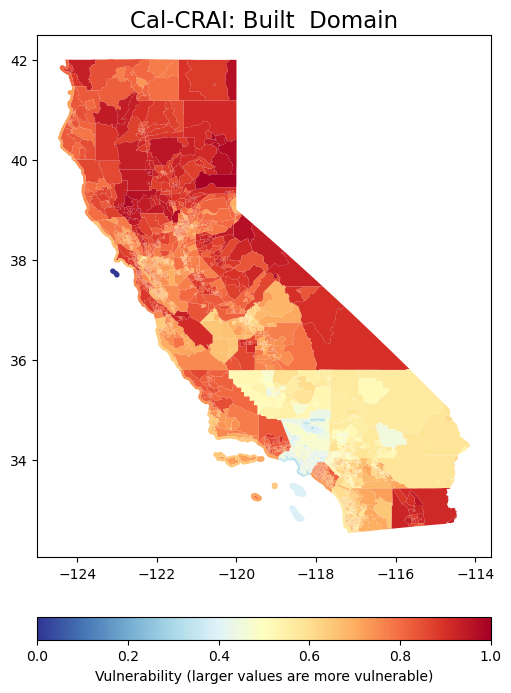

In [21]:
plot_domain(gdf, domain=domain_prefix)

### We can also visualize specific areas!
We call from a the `plot_region_domain` function which has a number of variables:

gdf : GeoDataFrame
    A GeoDataFrame containing the data you want to plot, which must include the column 'GEOID' to match with the census tract data.

counties_to_plot : list of str, optional
    A list of county FIPS codes (as strings) to plot. If None, no counties will be plotted.
    Example: ['037', '071', '065', '029', '111'].

region : str, optional
    A predefined region to plot. Options: 'bay_area', 'central_region', 'inland_deserts', 'north_central', 'northern', or 'south_coast'.
    If specified, this will override `counties_to_plot`.

plot_all : bool, optional
    If True, plots all counties in California. Overrides `counties_to_plot` and `region`.

savefig : bool, optional
    If True, the plot will be saved as a PNG file. Default is False.

font_color : str, optional
    Color of the font for county labels. Default is 'black'.

domain_name : str, optional
    Name of the domain to include in the plot title. Default is 'Society and Economy Domain'.


    Dictionary of county labels
    county_labels = {
        '001': 'Alameda', '003': 'Alpine', '005': 'Amador', '007': 'Butte', '009': 'Calaveras',
        '011': 'Colusa', '013': 'Contra Costa', '015': 'Del Norte', '017': 'El Dorado', '019': 'Fresno',
        '021': 'Glenn', '023': 'Humboldt', '025': 'Imperial', '027': 'Inyo', '029': 'Kern',
        '031': 'Kings', '033': 'Lake', '035': 'Lassen', '037': 'Los Angeles', '039': 'Madera',
        '041': 'Marin', '043': 'Mariposa', '045': 'Mendocino', '047': 'Merced', '049': 'Modoc',
        '051': 'Mono', '053': 'Monterey', '055': 'Napa', '057': 'Nevada', '059': 'Orange',
        '061': 'Placer', '063': 'Plumas', '065': 'Riverside', '067': 'Sacramento', '069': 'San Benito',
        '071': 'San Bernardino', '073': 'San Diego', '075': 'San Francisco', '077': 'San Joaquin',
        '079': 'San Luis Obispo', '081': 'San Mateo', '083': 'Santa Barbara', '085': 'Santa Clara',
        '087': 'Santa Cruz', '089': 'Shasta', '091': 'Sierra', '093': 'Siskiyou', '095': 'Solano',
        '097': 'Sonoma', '099': 'Stanislaus', '101': 'Sutter', '103': 'Tehama', '105': 'Trinity',
        '107': 'Tulare', '109': 'Tuolumne', '111': 'Ventura', '113': 'Yolo', '115': 'Yuba'

You can plot a domains vulnerability index by region, specific county/counties, or the entirety of CA with labels
Below are a few example of each of these plotting scenarios

Number of invalid geometries: 0


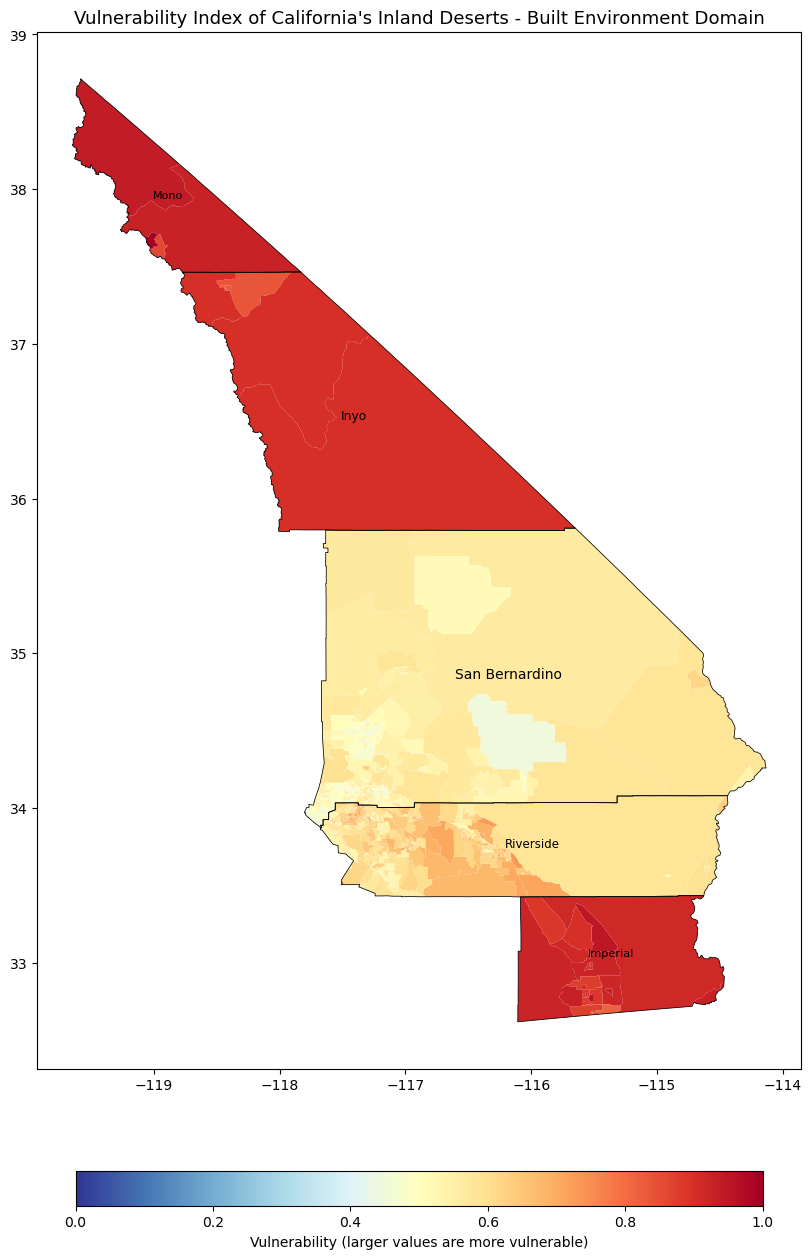

In [22]:
plot_region_domain(min_max_standardized_built_environment_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Built Environment Domain'}, region='inland_deserts', savefig=False, font_color='black')

Number of invalid geometries: 0


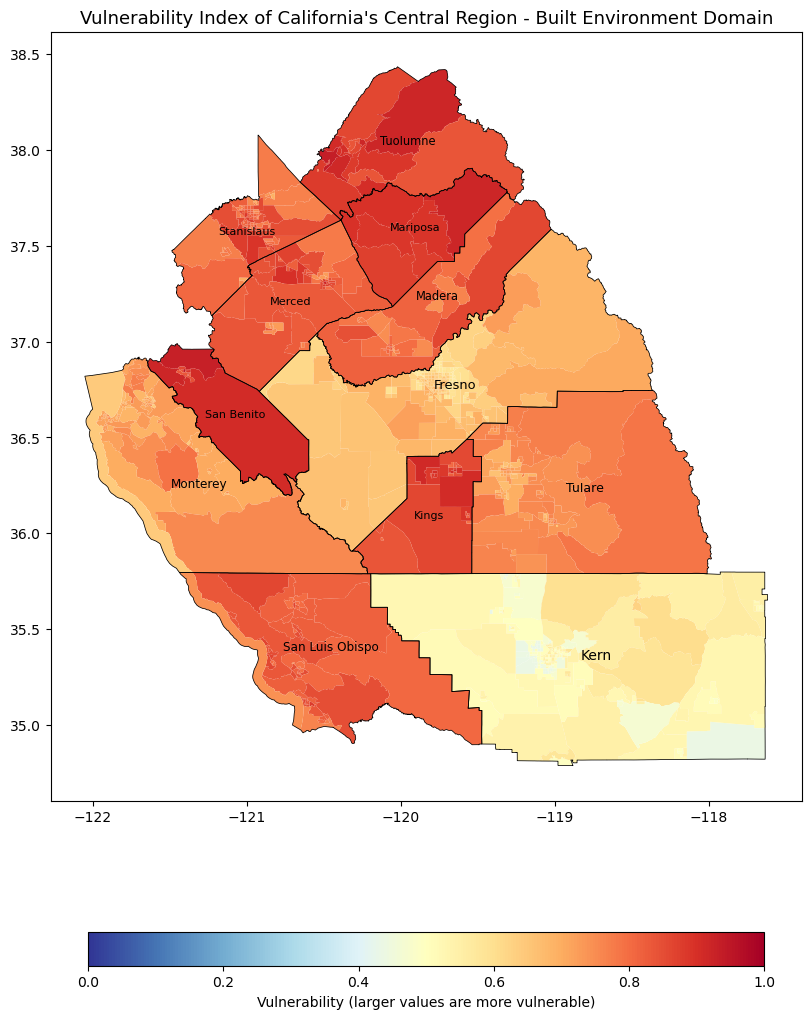

In [23]:
plot_region_domain(min_max_standardized_built_environment_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Built Environment Domain'}, region='central_region', savefig=False, font_color='black')

Number of invalid geometries: 0


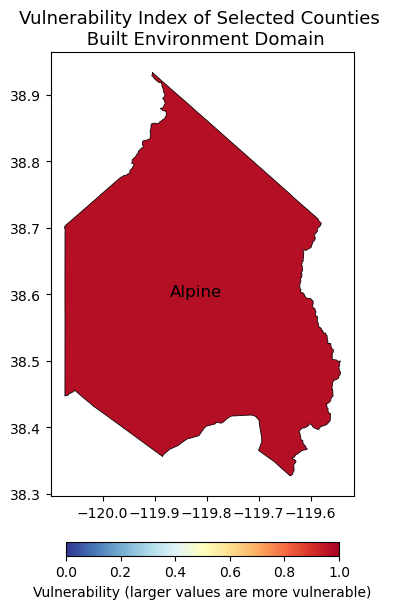

In [24]:
list_of_counties = ['003']
plot_region_domain(min_max_standardized_built_environment_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Built Environment Domain'}, counties_to_plot=list_of_counties, savefig=False, font_color='black')

Number of invalid geometries: 0


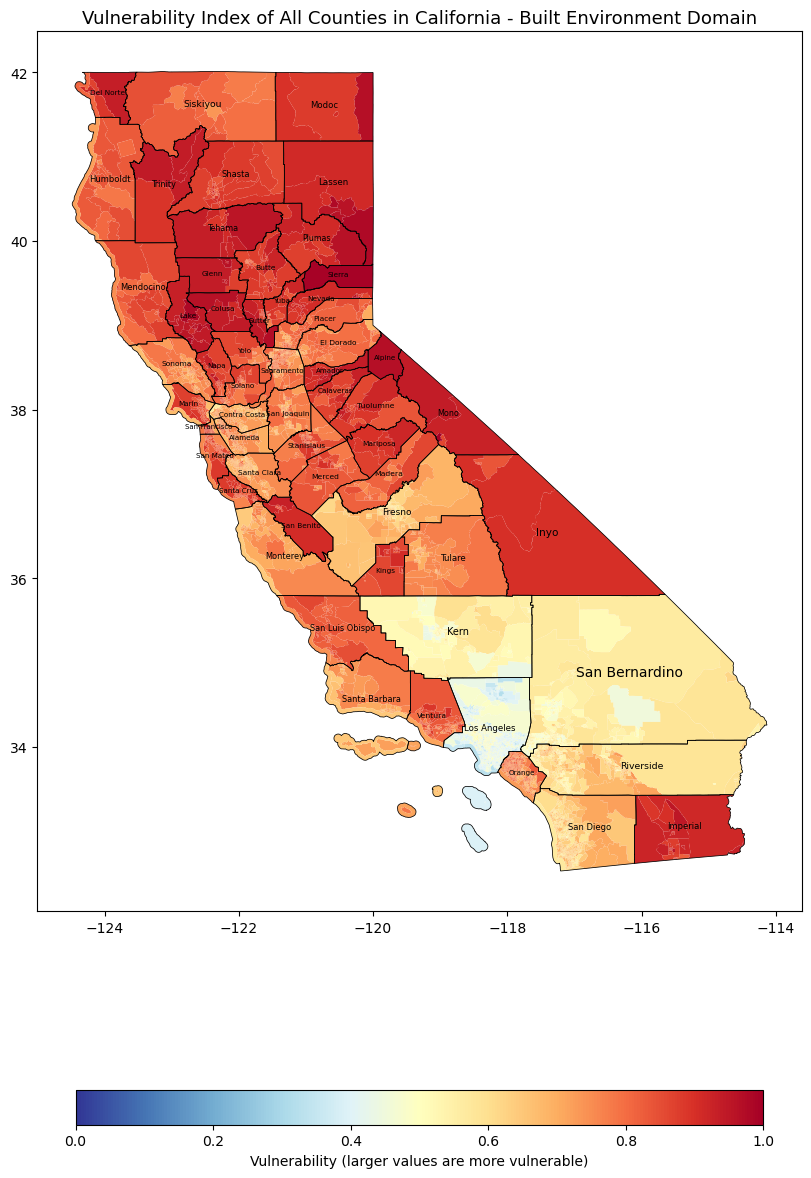

In [25]:
plot_region_domain(min_max_standardized_built_environment_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Built Environment Domain'}, plot_all=True, savefig=False, font_color='black')

## Step 4: Export the final domain csv file

In [17]:
# set-up file for export
filename = '{}index_data.csv'.format(domain_prefix)
gdf.to_csv(filename, index=False)

# export to AWS (Cal-CRAI)
directory = '3_fair_data/domain_standardized_data'
upload_csv_aws([filename], bucket_name, directory)